In [4]:
# For data handling
import pandas as pd

# For array and numerical computations
import numpy as np

# For convenient iteration tools
import itertools

# For text processing
import re

# For file management
import os
import glob
import json

# Scikit preprocessing and scores
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

# Scikit models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# For vizualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")

# For stored python objects (pre-computed)
import pickle

In [5]:
JSON_ROOT = "whoscored/"

standings_data = glob.glob(JSON_ROOT + "standingsData/*.json")

match_links_data = glob.glob(JSON_ROOT + "matchLinksData/*.json")

match_report_data = glob.glob(JSON_ROOT + "matchReportData/*.json")

team_data = glob.glob(JSON_ROOT + "teamData/*.json")

# Function to compute model metrics (accuracy and confusion matrix)

In [6]:
# Score and visualization functions

def compute_scores(y_train, y_val, preds_train, preds_val):
        # Compute many common metrics
        train_acc = metrics.accuracy_score(y_train, preds_train)
        val_acc = metrics.accuracy_score(y_val, preds_val)
        
        confusion_matrix_train = confusion_matrix(y_train, preds_train)
        confusion_matrix_val = confusion_matrix(y_val, preds_val)
        
        # Normalize the confusion matrix row wise
        confusion_matrix_train = confusion_matrix_train.astype('float') / confusion_matrix_train.sum(axis=1)[:, np.newaxis]
        confusion_matrix_val = confusion_matrix_val.astype('float') / confusion_matrix_val.sum(axis=1)[:, np.newaxis]

        scores = {"train_acc":train_acc,
                  "confusion_matrix_train":confusion_matrix_train,
                  "val_acc":val_acc,
                  "confusion_matrix_val":confusion_matrix_val}
        
        return scores
    
def display_score(scores, print_confusion=True):
        print("Train acc: " + str(scores["train_acc"]))
        print("Val acc: " + str(scores["val_acc"]))
        
        # Plot Confusion matrices, Can disable if we only want to print the losses
        if (print_confusion):
            fig = plt.figure(figsize=(11,9))
            plt.subplots_adjust(right = 2)
            plt.subplot(1,2,1)
            plt.title("Confusion matrix Train",fontsize=25)
            heatmap = sns.heatmap(scores["confusion_matrix_train"], annot=True, fmt='.2f', cmap=plt.get_cmap('Blues'))
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=20)
            heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=20)
            plt.ylabel('True label',fontsize=25)
            plt.xlabel('Predicted label', fontsize=25)

            plt.subplot(1,2,2)
            plt.title("Confusion matrix Val",fontsize=25)
            heatmap = sns.heatmap(scores["confusion_matrix_val"], annot=True, fmt='.2f', cmap=plt.get_cmap('Blues'))
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=20)
            heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=20)
            plt.ylabel('True label',fontsize=25)
            plt.xlabel('Predicted label',fontsize=25)

# Functions to get data from JSON files into dataframe

In [7]:
# Declare empty DataFrame that we will fill iteratively
df_standings = pd.DataFrame()

for standing in standings_data:
    df_standings = df_standings.append(pd.read_json(standing))
    


df_players = pd.DataFrame(columns=["date", "player_id", "player_name", "avg_rating_sorted", "success_passes", "shots_per_game", "aerial_won_per_game", "goals"] )

for team_data_file in team_data:
    
    date = team_data_file.split("_")[-1].split(".")[0]
    with open(team_data_file, 'r') as f:
        js = json.load(f)
        # summary_data, defensive_data, offensive_data, passing_data, detailed_data, here we will focus only on summary for now
        data = js["summary_data"]
        for i in data:
            player_name = i["player_link"].split("/")[-1]
            player_id = i["player_name"].split("/")[2]
            avg_rating = i['rating_sorted']
            success_passes = i["success_passes"]
            shots_per_game = i["shots_per_game"]
            aerial_won_per_game = i["aerial_won_per_game"]
            goals = i["goals"]
            # Now we add entry into DataFrame
            df_players = df_players.append(dict(zip(df_players.columns, [date, player_id, player_name, avg_rating, success_passes, shots_per_game, aerial_won_per_game, goals])), ignore_index=True)
        
# Let's fix the tabulation char and null values, turn to numeric values
df_players["avg_rating_sorted"] = pd.to_numeric(df_players["avg_rating_sorted"], errors='coerce')
df_players["success_passes"] = pd.to_numeric(df_players["success_passes"], errors='coerce')
df_players["shots_per_game"] = pd.to_numeric(df_players["shots_per_game"], errors='coerce')
df_players["aerial_won_per_game"] = pd.to_numeric(df_players["aerial_won_per_game"], errors='coerce')
df_players["goals"] = pd.to_numeric(df_players["goals"], errors='coerce')

# change NaN with zero
df_players = df_players.fillna(0)

# let's build a list containing each match using the data in the JSON file
matches = []
# and let's store match_url for score scrapping since we miss it
matches_url = []

# Let's get a list of all matches played
for match_link_file in match_links_data:
    with open(match_link_file, 'r') as f:
        js = json.load(f)
        
        for j in js:
            match_text = list(j.values())[0]
            match_name = match_text.split("MatchReport/")[-1]
            date = match_text.split("-")[2] + "-" + match_text.split("-")[3]
            matches.append(match_name + "_" + date)
            
            matches_url.append(match_text)
            
        #matches_dict.update(js)
        
# Write function to get match report from match 
def get_match_report(match):
    with open(JSON_ROOT + "matchReportData/" + str(match) + ".json", 'r') as f:
        js = json.load(f)
    return js

# Get team names from a match entry
def get_team_names_from_matches(match):
    team_name_parts = match.split("_")[0].split("-")[4:]
    if team_name_parts[0] in dict_team_name_to_files:
        return (team_name_parts[0], ' '.join(team_name_parts[1:]) )
    else:
        return  ( ' '.join(team_name_parts[0:2]), ' '.join(team_name_parts[2:]) )

# Get date from match entry
def get_date_from_matches(match):
    team_name_parts = match.split("_")[1]
    return team_name_parts

 # Load match scores from pickle file 
with open('match_score.pkl', 'rb') as handle:
    matches_score_pickle = pickle.load(handle)
    
 # Load match dates from pickle file 
with open('match_dates.pkl', 'rb') as handle:
    matches_date = pickle.load(handle)
    
# Get team player information for one season
def get_team_data(team_name, date):
    with open(JSON_ROOT + "teamData/" + str(team_name) + "_" + date + ".json", 'r') as f:
        js = json.load(f)
    return js


# Get score from 10 last matches

In [ ]:
# First we construct a list with the following element [date, match_name (contains team names), score]
matches_with_date = [(pd.to_datetime(d), m, get_result(s)) for d, m, s in zip(matches_date, matches, matches_score_pickle)]

# Then we sort the list by date
matches_with_date.sort()

# Then we generate two dictionnary that we will fill with the scores for each team
matches_record = {team_name: [] for team_name in d}
matches_dates = {team_name: [] for team_name in d}

In [ ]:
# We go through all the matches by date order and we fill the dictionnary by appeding to the list of each team
for i in range(len(matches_with_date)):
    date = matches_with_date[i][0]
    t1, t2 = get_team_names_from_matches(matches_with_date[i][1])
    score = int(matches_with_date[i][2])
    
    scores_diff = (0,0)
    if score == 0:
        scores_diff = (3,0)
    elif score == 1:
        scores_diff = (1,1)
    elif score == 2:
        scores_diff = (0,3)
    
    matches_record[t1].append(scores_diff[0])
    matches_record[t2].append(scores_diff[1])
    
    matches_dates[t1].append(date)
    matches_dates[t2].append(date)

### To get points from ten last matches we do the following:

In [ ]:
# Get the list of the matches 
t1_matches = matches_record["Bayern Munich"]
# example [3,3,0,1,0, ..., 1,3]

t1_matches_dates = matches_dates["Bayern Munich"]
# example [Timestamp('2014-09-13 00:00:00'), Timestamp('2014-09-20 00:00:00'), Timestamp('2014-09-23 00:00:00')]

# Now for a given date we can the index of its match in the list
idx = t1_matches_dates.index(date)

# Then from the index we can take 10 last scores
ten_last = t1_matches[idx-10:idx]
# example = [1,1,3,3,0,3,3,0,3,3]

# Then we just sum those 10 matches score to get the final points from ten last matches
np.sum(ten_last)
# example = 20

# Helper function to to turn data into features

In [2]:
# Standing feature processing
def get_standings_features(df):
    return [df["pts"].values[0], df["d"].values[0], df["ga"].values[0], df["gd"].values[0], df["gf"].values[0], df["l"].values[0], df["p"].values[0], df["w"].values[0]]

def update_feature_dict(f_dict, f_name, m_r, team):
    # re.sub is regexp expresison to only keep number and remove % symbol
    try:
        f_dict[f_name] += int(re.sub("[^0-9]", "", m_r[f_name][team]))
    except:
        print(f_name + " " + team + " failed")
    
# Past matches features processing
def get_past_matches_features(matches, team):
    
    features_dict = {"total_attempts":0,
                    "open_play":0,
                    "set_price":0,
                    "counter_attack":0,
                    "penalty":0,
                    "own_goal":0,
                    "total_passes":0,
                    "crosses":0,
                    "through_balls":0,
                    "long_balls":0,
                    "short_passes":0,
                    "shots":0,
                    "shots_on_target":0,
                    "pass_success":0,
                    "aerial_duel_success":0,
                    "dribbles_won":0,
                    "tackles":0,
                    "possession":0} 
    
    for m in matches:
        m_r = get_match_report(m)
        
        update_feature_dict(features_dict, "total_attempts", m_r["live_goals"], team)
        update_feature_dict(features_dict, "open_play", m_r["live_goals"], team)
        update_feature_dict(features_dict, "set_price", m_r["live_goals"], team)
        update_feature_dict(features_dict, "counter_attack", m_r["live_goals"], team)
        update_feature_dict(features_dict, "penalty", m_r["live_goals"], team)
        update_feature_dict(features_dict, "own_goal", m_r["live_goals"], team)
        
        update_feature_dict(features_dict, "total_passes", m_r["live_passes"], team)
        update_feature_dict(features_dict, "crosses", m_r["live_passes"], team)
        update_feature_dict(features_dict, "through_balls", m_r["live_passes"], team)
        update_feature_dict(features_dict, "long_balls", m_r["live_passes"], team)
        update_feature_dict(features_dict, "short_passes", m_r["live_passes"], team)
        
        update_feature_dict(features_dict, "shots", m_r["match_stats"], team)
        update_feature_dict(features_dict, "shots_on_target", m_r["match_stats"], team)
        update_feature_dict(features_dict, "pass_success", m_r["match_stats"], team)
        update_feature_dict(features_dict, "aerial_duel_success", m_r["match_stats"], team)
        update_feature_dict(features_dict, "dribbles_won", m_r["match_stats"], team)
        update_feature_dict(features_dict, "tackles", m_r["match_stats"], team)
        update_feature_dict(features_dict, "possession", m_r["match_stats"], team)

    return list(map(lambda x: x / len(matches), features_dict.values()))

# Process feature from team player
def get_team_players_past_features(team_data, previous_season):
    avg_rating = []
    success_passes = []
    shots_per_game = []
    aerial_won_per_game = []
    goals = []
    
    for p in team_data['summary_data']:
        player_id = p['player_name'].split("/")[2]
        stats = df_players[df_players["player_id"] == player_id]
        stats = stats[stats["date"] == previous_season]
        avg_rating.append(stats["avg_rating_sorted"].values[0])
        success_passes.append(stats["success_passes"].values[0])
        shots_per_game.append(stats["shots_per_game"].values[0])
        aerial_won_per_game.append(stats["aerial_won_per_game"].values[0])
        goals.append(stats["goals"].values[0])
        
    return [np.mean(avg_rating), np.mean(success_passes), np.mean(shots_per_game), np.mean(aerial_won_per_game), np.mean(goals)]


# Code to generate match features from JSON data extracted above

In [28]:
def make_match_entry(match, match_score, match_date):
    
    match_report = get_match_report(match)
    
    team_name1 = match_report["team1_name"]
    team_name2 = match_report["team2_name"]

    #if date is 2015-2016 we turn to 2014 - 2015 in previous_season
    date = get_date_from_matches(match)
    previous_season = str(int(date.split("-")[-1], 10) - 2) + "-" + str(date.split("-")[0]) 
    
    # Check if there is data from previous season
    try:
        team_data1 = get_team_data(team_name1, previous_season)
        team_data2 = get_team_data(team_name2, previous_season)
    except:
        return
    
    t1, t2 = get_team_names_from_matches(match)
    
    # Use matches_record and matches_dates to generate score from 10 last matches
    t1_matches = matches_record[t1]
    t1_matches_dates = matches_dates[t1]
    idx = t1_matches_dates.index(match_date)
    ten_last = t1_matches[idx-10:idx]
    t1_curr_points = np.sum(ten_last)
    
    t2_matches = matches_record[t2]
    t2_matches_dates = matches_dates[t2]
    idx = t2_matches_dates.index(match_date)
    ten_last = t2_matches[idx-10:idx]
    t2_curr_points = np.sum(ten_last)
    
    # Get past season player features using above helpers functions
    team1_player_combined = get_team_players_past_features(team_data1, previous_season)
    team2_player_combined = get_team_players_past_features(team_data2, previous_season)
    
    # Get standing features using above helper functions
    df_standing_previous = df_standings[df_standings["season"] == previous_season]
    team1_standings_features = get_standings_features(df_standing_previous[df_standing_previous["team_name"] == team_name1])
    team2_standings_features = get_standings_features(df_standing_previous[df_standing_previous["team_name"] == team_name2])
    
    # Let's collect past match avg features for match_report using above helpers functions:
    # First we need to find all matches from previous season where team1 played and where team2 played using df_matches
    team1_matches_last_season = df_matches[((df_matches["team1"] == team_name1) | (df_matches["team2"] == team_name1)) & (df_matches["season"] == date)]
    matches_team1 = team1_matches_last_season.apply(lambda x: "Germany-Bundesliga-" + x["season"] + "-" + dict_team_name_to_files[x["team1"]] + "-"  +  dict_team_name_to_files[x["team2"]] + "_" + x["season"], axis=1)
    
    team2_matches_last_season = df_matches[((df_matches["team1"] == team_name2) | (df_matches["team2"] == team_name2)) & (df_matches["season"] == date)]
    matches_team2 = team2_matches_last_season.apply(lambda x: "Germany-Bundesliga-" + x["season"] + "-" + dict_team_name_to_files[x["team1"]] + "-"  +  dict_team_name_to_files[x["team2"]] + "_" + x["season"], axis=1)
    
    team1_past_matches_features = get_past_matches_features(matches_team1, "team1")
    team2_past_matches_features = get_past_matches_features(matches_team2, "team2")
    
    return date, previous_season, team_name1, team1_standings_features, team1_past_matches_features, team1_player_combined, team_name2, team2_standings_features, team2_past_matches_features, team2_player_combined, match_score, t1_curr_points, t2_curr_points



# Generate the final dataframe using the make entry function that generates features for each match entry

In [31]:
# Supposing new_columns has corrected colum names
df_matches_all = pd.DataFrame(columns=new_columns + ["is_train"])
for m_date, m, m_score in matches_with_date:
    entry = make_match_entry(m, m_score, m_date)
    if entry:
        s, s_p, t1, t1sf, t1pmf, t1pc, t2, t2sf, t2pmf, t2pc, score_cat, t1_curr, t2_curr = entry
        
        # Decide randomly if it is train or validation data and separ
        is_train = False
        if random.uniform(0,1) > VAL_PROB:
            is_train = True
        
        # Add team HOME, not home
        df_matches_all = df_matches_all.append(dict(zip(df_matches_all.columns, list(itertools.chain.from_iterable([[s], [s_p], [t1], [t2], [True], [score_cat], t1sf, t1pmf, t1pc, [t1_curr], t2sf, t2pmf, t2pc, [t2_curr], [is_train]])))), ignore_index=True)
        if score_cat == 0:
            score_cat = 2
        elif score_cat == 2:
            score_cat = 0
        df_matches_all = df_matches_all.append(dict(zip(df_matches_all.columns, list(itertools.chain.from_iterable([[s], [s_p], [t2], [t1], [False], [score_cat], t2sf, t2pmf, t2pc, [t2_curr], t1sf, t1pmf, t1pc, [t1_curr], [is_train]])))), ignore_index=True)

        


# DF Final

##### DF generated above contains features that we don't want to include in the end so we remove it in the two lines below

In [42]:
df_final = df_matches_all[['team1_home', 'match_result', 'team1_current_pts', 'team1_success_passes', 'team1_avg_rating', 'team2_current_pts', 'team2_success_passes', 'team2_avg_rating', 'is_train' ]]
df_final = df_final.rename(index=str, columns={"team1_current_pts":"team1_last10", "team2_current_pts":"team2_last10"})

In [43]:
df_final.head()

,team1_home,match_result,team1_last10,team1_success_passes,team1_avg_rating,team2_last10,team2_success_passes,team2_avg_rating,is_train
0,True,2,25,76.584211,6.988947,10,68.335484,6.716129,True
1,False,0,10,68.335484,6.716129,25,76.584211,6.988947,True
2,True,0,18,85.607407,7.078148,11,71.180000,6.703200,True
3,False,2,11,71.180000,6.703200,18,85.607407,7.078148,True
4,True,0,12,71.184615,6.746154,12,70.104348,6.677391,True


# ML parts using the feature

In [ ]:
X =  np.asanyarray(df_final)
y = df_final["match_result"].values.astype('int')

train_data = df_final[df_final["is_train"] == True]
val_data = df_final[df_final["is_train"] == False]

X_train = np.asanyarray(train_data.drop(columns=["match_result", "is_train"]))
y_train = np.asanyarray(train_data["match_result"].values.astype('int'))

X_val = np.asanyarray(val_data.drop(columns=["match_result", "is_train"]))
y_val = np.asanyarray(val_data["match_result"].values.astype('int'))

# Feed data to the random forest

In [ ]:
classifier = RandomForestClassifier(max_depth=5, n_estimators=25)
classifier.fit(X_train, y_train)

# Use the trained model to check accuracy on the dataset

Train acc: 0.5559322033898305
Val acc: 0.47601476014760147


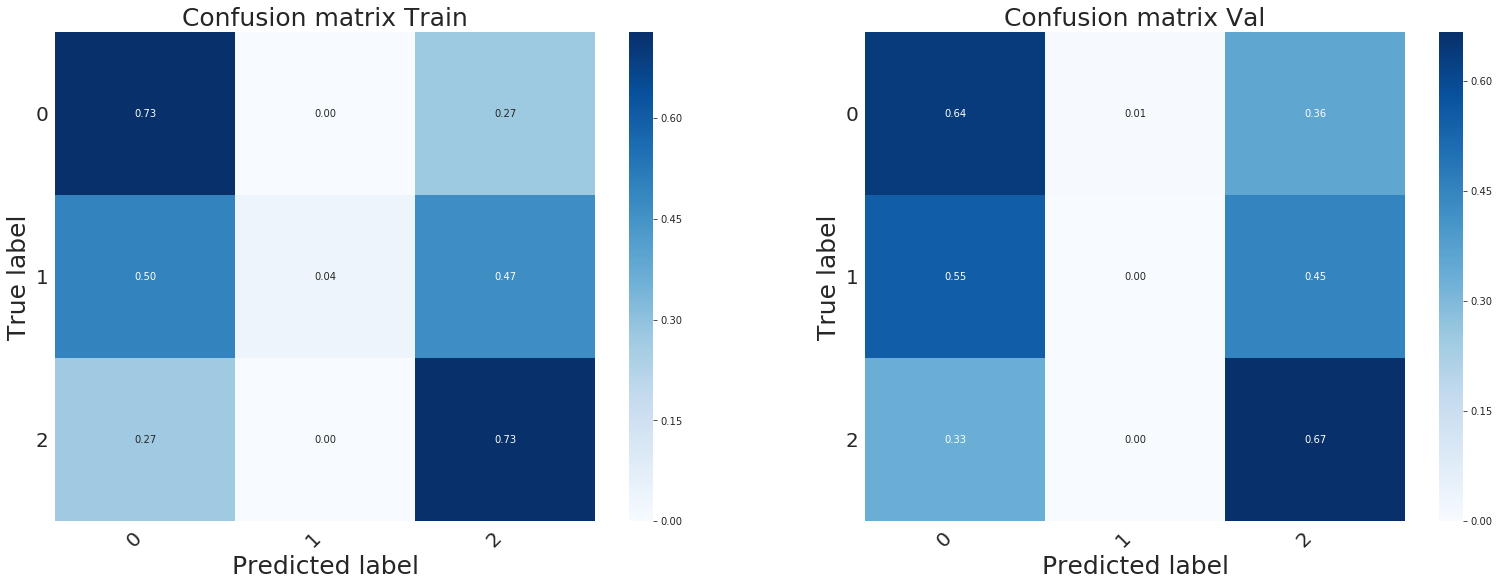

In [67]:
train_pred = classifier.predict(X_train)
val_pred = classifier.predict(X_val)

display_score(compute_scores(y_train, y_val, train_pred, val_pred))